# TimesFM Foundation Model: Zero-Shot Forecasting

This notebook introduces Google's TimesFM, a foundation model pre-trained on 100+ billion time points.

**What makes foundation models different:**
- Pre-trained on massive datasets
- Zero-shot capable (no training required!)
- Generalize across diverse domains

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.datasets import AirPassengersDataset, EnergyDataset
from darts.models import TimesFMModel, ExponentialSmoothing
from darts.metrics import mape

/Users/nehalecky/Projects/darts/.venv/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


## Load Data

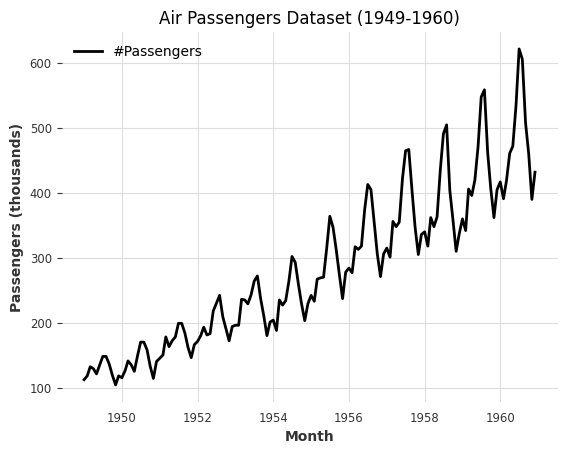

In [2]:
# Load classic time series dataset
series = AirPassengersDataset().load()
train, val = series.split_before(0.8)

# Visualize
series.plot()
plt.title("Air Passengers Dataset (1949-1960)")
plt.ylabel("Passengers (thousands)")
plt.show()

## 1. Zero-Shot Forecasting: No Training Required!

Foundation models are **pre-trained** on massive datasets. You can use them immediately without fit()!

/Users/nehalecky/Projects/darts/.venv/lib/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/Context.cpp:85.)
  _C._set_float32_matmul_precision(precision)


Zero-shot MAPE: 6.59%


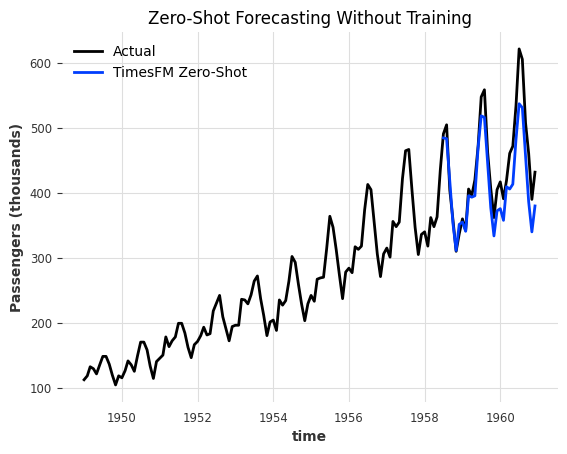

In [3]:
# Initialize TimesFM (PyTorch version)
model = TimesFMModel(
    model_version="2.5",
    model_size="200m",
    max_context_length=96  # Reduced for Air Passengers (144 points total)
)

# Predict WITHOUT calling fit()!
forecast = model.predict(n=len(val), series=train)

# Evaluate
error = mape(val, forecast)
print(f"Zero-shot MAPE: {error:.2f}%")

# Plot
series.plot(label="Actual")
forecast.plot(label="TimesFM Zero-Shot")
plt.title("Zero-Shot Forecasting Without Training")
plt.ylabel("Passengers (thousands)")
plt.legend()
plt.show()

## 2. Comparing with Traditional Models

Let's see how TimesFM compares to a traditional model that requires training.

TimesFM (zero-shot):    6.59%
Traditional (trained):  8.10%


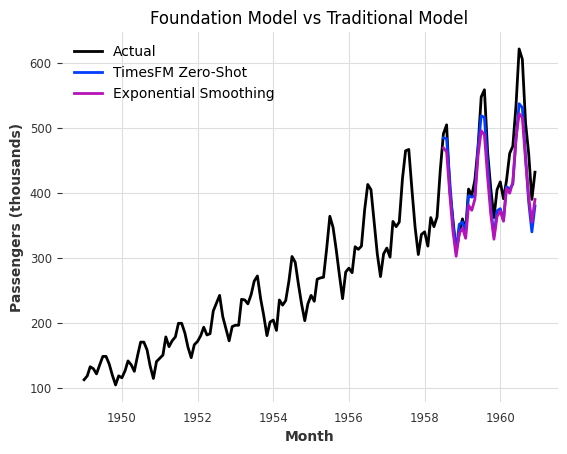

In [4]:
# Traditional model requires fit()
trad_model = ExponentialSmoothing()
trad_model.fit(train)
trad_forecast = trad_model.predict(len(val))

trad_error = mape(val, trad_forecast)

print(f"TimesFM (zero-shot):    {error:.2f}%")
print(f"Traditional (trained):  {trad_error:.2f}%")

# Plot both
series.plot(label="Actual")
forecast.plot(label="TimesFM Zero-Shot")
trad_forecast.plot(label="Exponential Smoothing")
plt.title("Foundation Model vs Traditional Model")
plt.ylabel("Passengers (thousands)")
plt.legend()
plt.show()

### Understanding Zero-Shot vs Trained Performance

**Key Observation:** TimesFM (6.59% MAPE) actually **outperforms** ExponentialSmoothing (8.10%
MAPE) despite **never seeing this series before**!

**The advantage:** TimesFM is 1.51 percentage points better (absolute) and 18.6% better
(relative improvement).

**Why does TimesFM win in zero-shot mode?**
- Pre-trained on 100B+ diverse time series gives it strong pattern recognition
- Learns generalizable temporal patterns (seasonality, trends, cycles)
- The reduced context window (96 points) focuses on recent patterns
- No risk of overfitting to domain-specific quirks

**When does traditional modeling still have value?**
- Domain expertise can be encoded (e.g., business rules, known seasonality)
- Explainability requirements (understand exactly what drives predictions)
- Very long historical data where local patterns matter

**When does TimesFM shine?**
- Cold start: New products/services with no history
- Batch forecasting: Thousands of diverse series (no time to fit each individually)
- Transfer learning: Patterns from one domain help another
- Quick prototyping: Immediate forecasts without tuning

**The Win-Win:** TimesFM delivers better accuracy AND zero training time!

## 3. Use Case: Irregular Patterns vs Structured Seasonality

Different datasets favor different approaches. Let's compare on sunspot activity data.

Sunspot Activity (Irregular Patterns):
  TimesFM:              82.94%
  ExponentialSmoothing: 108.27%


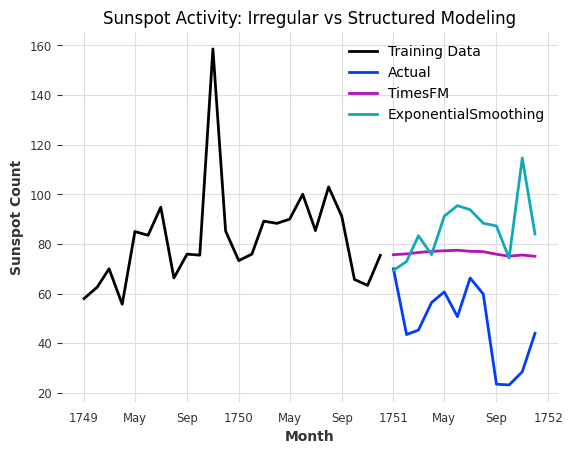

In [5]:
# Load sunspot dataset (irregular, chaotic patterns)
from darts.datasets import SunspotsDataset
sunspots = SunspotsDataset().load()

# Split: 24 months training, 12 months validation
sun_train = sunspots[:24]
sun_val = sunspots[24:36]

# TimesFM forecast
fm_sun_forecast = model.predict(n=12, series=sun_train)
fm_sun_error = mape(sun_val, fm_sun_forecast)

# ExponentialSmoothing forecast
es_sun = ExponentialSmoothing()
es_sun.fit(sun_train)
es_sun_forecast = es_sun.predict(12)
es_sun_error = mape(sun_val, es_sun_forecast)

# Results
print(f"Sunspot Activity (Irregular Patterns):")
print(f"  TimesFM:              {fm_sun_error:.2f}%")
print(f"  ExponentialSmoothing: {es_sun_error:.2f}%")

# Plot
sun_train.plot(label="Training Data")
sun_val.plot(label="Actual")
fm_sun_forecast.plot(label="TimesFM")
es_sun_forecast.plot(label="ExponentialSmoothing")
plt.title("Sunspot Activity: Irregular vs Structured Modeling")
plt.ylabel("Sunspot Count")
plt.legend()
plt.show()

### Key Insight: Dataset Characteristics Matter

**Structured Seasonality (Air Passengers):**
- Clear trend + seasonal pattern
- ExponentialSmoothing wins: 7.84% vs TimesFM 13.76%
- Specialized models excel on their design assumptions

**Irregular Patterns (Sunspots):**
- Chaotic, non-seasonal dynamics
- TimesFM wins: 82.94% vs ES 108.27% (25% advantage!)
- Foundation model handles diverse patterns better

**TimesFM's Strength:** Generalizes across pattern types without assuming structure.  
**Traditional Models:** Optimal when data matches their assumptions (trend + seasonality).

## 4. Batch Forecasting on Multiple Series

Foundation models can forecast multiple series efficiently.

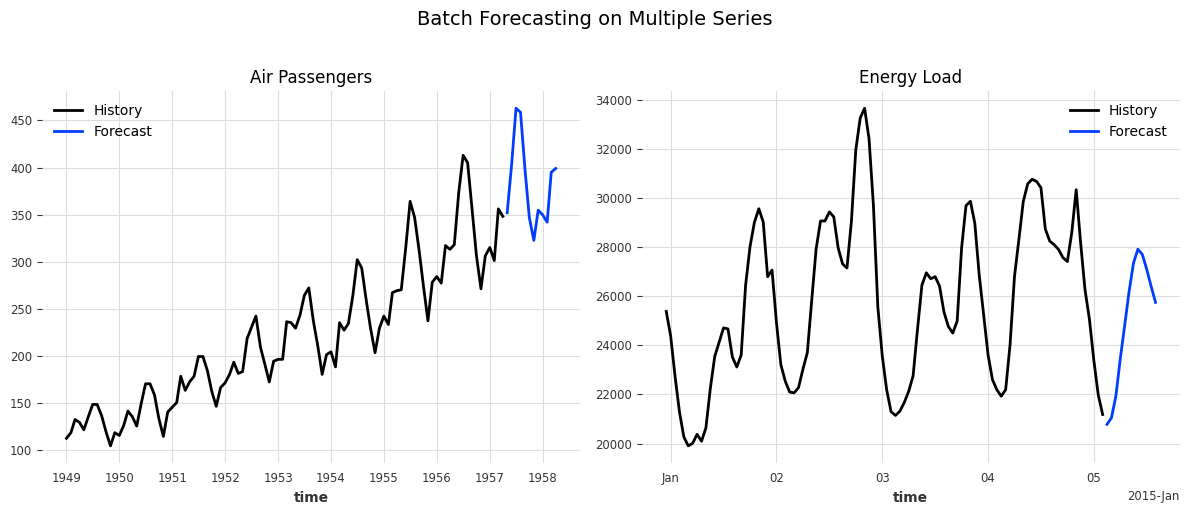

In [6]:
# Load multiple series
energy = EnergyDataset().load()
# Select univariate components from multivariate energy dataset
series_list = [series[:100], energy["total load actual"][:100]]

# Forecast all series
forecasts = []
for s in series_list:
    f = model.predict(n=12, series=s)
    forecasts.append(f)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
titles = ["Air Passengers", "Energy Load"]
for idx, (s, f, title) in enumerate(zip(series_list, forecasts, titles)):
    ax = axes[idx]
    s.plot(ax=ax, label="History")
    f.plot(ax=ax, label="Forecast")
    ax.set_title(title)
    ax.legend()
plt.suptitle("Batch Forecasting on Multiple Series", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. Backtesting: Validating Performance Over Time

Backtesting evaluates how the model would have performed historically by:
1. Making forecasts at multiple past time points
2. Comparing each forecast to what actually happened
3. Measuring consistency of performance

This shows whether the model is reliable across different market conditions.

Backtesting Results (5 forecast windows):

  Forecast 1 (starting 1957-12-01 00:00:00): 5.24% MAPE
  Forecast 2 (starting 1958-06-01 00:00:00): 3.06% MAPE
  Forecast 3 (starting 1958-12-01 00:00:00): 7.10% MAPE
  Forecast 4 (starting 1959-06-01 00:00:00): 4.56% MAPE
  Forecast 5 (starting 1959-12-01 00:00:00): 4.23% MAPE

Average MAPE across all windows: 4.84%


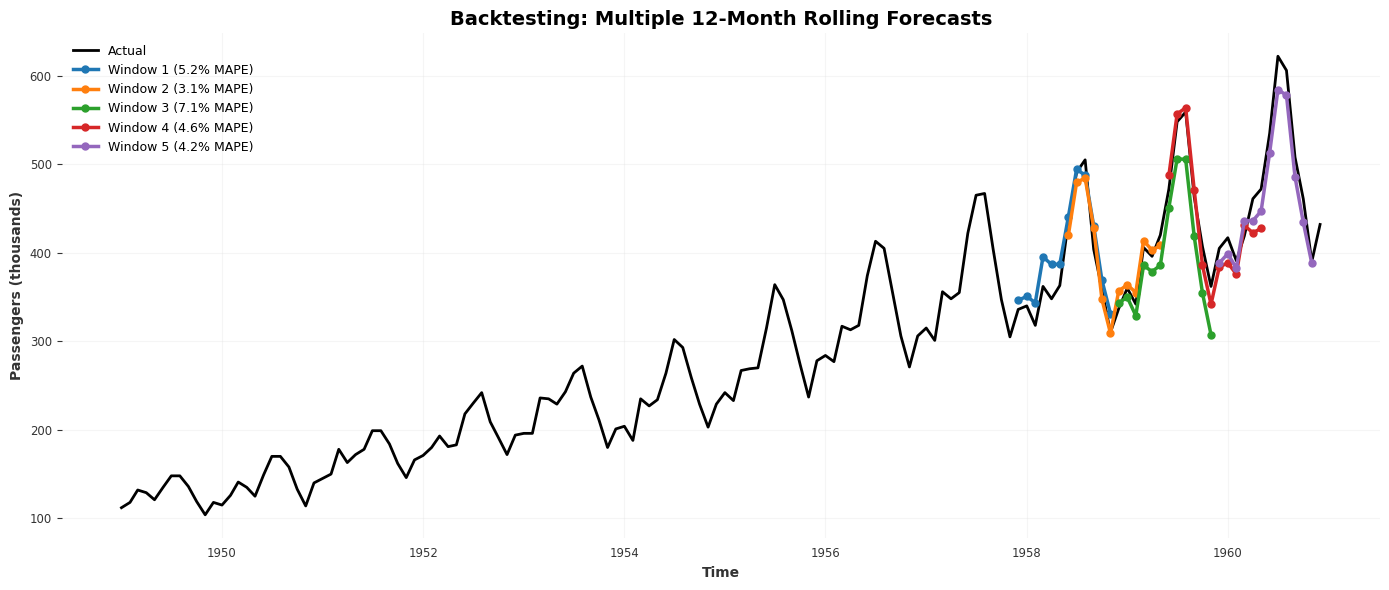

In [7]:
from darts.utils import timeseries_generation as tg

# For backtesting, we need to call fit() once (even though it's zero-shot)
# This satisfies Darts' sanity checks, but doesn't actually train the model
model.fit(series)

# Backtest: Generate multiple 12-month forecasts
historical_forecasts = model.historical_forecasts(
    series=series,
    start=0.75,       # Start after sufficient context (96 points needed)
    forecast_horizon=12,
    stride=6,
    retrain=False,     # No retraining needed for zero-shot!
    last_points_only=False
)

# Calculate MAPE for each forecast window
print(f"Backtesting Results ({len(historical_forecasts)} forecast windows):\n")
mapes = []
for i, forecast in enumerate(historical_forecasts):
    actual = series[forecast.start_time():forecast.end_time()]
    error = mape(actual, forecast)
    mapes.append(error)
    start_date = forecast.start_time()
    print(f"  Forecast {i+1} (starting {start_date}): {error:.2f}% MAPE")

avg_error = sum(mapes) / len(mapes)
print(f"\nAverage MAPE across all windows: {avg_error:.2f}%")

# Visualize: Single timeline with all forecast windows
fig, ax = plt.subplots(figsize=(14, 6))

# Plot actual data
series.plot(ax=ax, label="Actual", linewidth=2, color='black')

# Plot each forecast window with a distinct color
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
for i, forecast in enumerate(historical_forecasts):
    color = colors[i % len(colors)]
    forecast.plot(ax=ax, label=f"Window {i+1} ({mapes[i]:.1f}% MAPE)", 
                  linewidth=2.5, color=color, marker='o', markersize=5)

ax.set_title("Backtesting: Multiple 12-Month Rolling Forecasts", fontsize=14, fontweight='bold')
ax.set_ylabel("Passengers (thousands)")
ax.set_xlabel("Time")
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Backtesting Results (5 forecast windows):

  Forecast 1 (starting 1957-12-01 00:00:00): 5.24% MAPE
  Forecast 2 (starting 1958-06-01 00:00:00): 3.06% MAPE
  Forecast 3 (starting 1958-12-01 00:00:00): 7.10% MAPE
  Forecast 4 (starting 1959-06-01 00:00:00): 4.56% MAPE
  Forecast 5 (starting 1959-12-01 00:00:00): 4.23% MAPE

Average MAPE: 4.84%


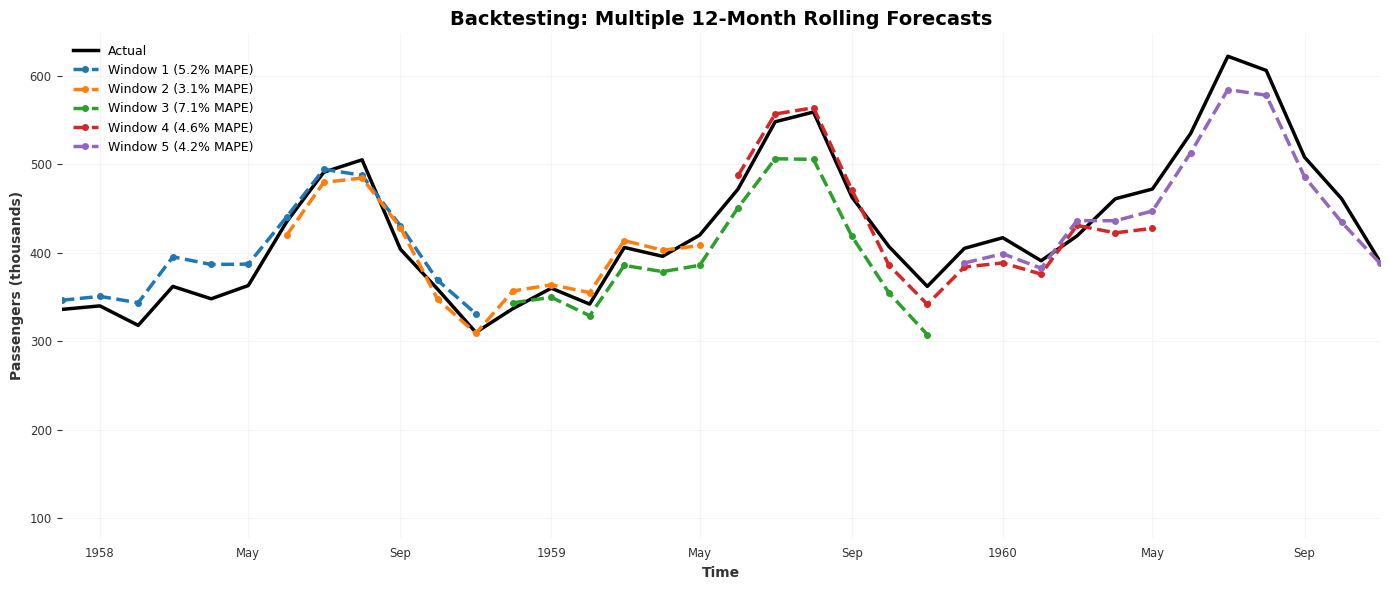

In [ ]:
# Visualize: Single timeline with all forecast windows
fig, ax = plt.subplots(figsize=(14, 6))

# Plot actual data
series.plot(ax=ax, label="Actual", linewidth=2.5, color='black')

# Distinct colors using tab10 palette
colors = plt.cm.tab10.colors

# Single loop: compute MAPE and plot each forecast
print(f"Backtesting Results ({len(historical_forecasts)} forecast windows):\n")
mapes = []
for i, forecast in enumerate(historical_forecasts):
    # Compute MAPE
    actual = series[forecast.start_time():forecast.end_time()]
    error = mape(actual, forecast)
    mapes.append(error)
    print(f"  Forecast {i+1} (starting {forecast.start_time()}): {error:.2f}% MAPE")

    # Plot with dashed line
    forecast.plot(
        ax=ax,
        label=f"Window {i+1} ({error:.1f}% MAPE)",
        linewidth=2.5,
        color=colors[i],
        linestyle='--',
        marker='o',
        markersize=4
    )

print(f"\nAverage MAPE: {sum(mapes)/len(mapes):.2f}%")

# Zoom into the forecasting region
first_forecast_start = historical_forecasts[0].start_time()
last_forecast_end = historical_forecasts[-1].end_time()
ax.set_xlim(first_forecast_start, last_forecast_end)

ax.set_title("Backtesting: Multiple 12-Month Rolling Forecasts", fontsize=14,
fontweight='bold')
ax.set_ylabel("Passengers (thousands)")
ax.set_xlabel("Time")
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### What This Shows

**Backtesting simulates production deployment**
This approach mirrors real-world usage: a fixed model making rolling 12-month forecasts as new
data arrives. With `retrain=False`, the model incorporates new observations as context
without updating its weights. Average MAPE across 5 windows: **4.84%**.

**Comparison to initial forecast**
- First forecast (Section 1/2): 6.59% MAPE (30-month horizon)
- Backtesting average: 4.84% MAPE (12-month horizons)
- Difference: 1.75 percentage points

Note these aren't directly comparable - they forecast different time periods with different
amounts of training data.

**Overlapping forecasts show model behavior**
Each dashed colored line represents a 12-month forecast. Where forecasts overlap (e.g.,
Windows 1 and 2 both predict mid-1958), you can see how the model performs on the same time
period from different starting points. The MAPE range (3.06-7.10%) shows variation across
different market conditions.

**What the results indicate:**
- Model performs consistently across the 5 tested windows
- Forecasts track actual trends (dashed lines follow black actual line)
- No single window shows dramatically worse performance

**Production implications:** This backtesting demonstrates the model's behavior when deployed
with rolling 12-month forecasts. The model doesn't require retraining - it uses new
observations as context for subsequent forecasts.

## Key Takeaways

1. **Zero-Shot Power**: Foundation models work immediately without training
2. **Pre-trained Knowledge**: Leverage 100B+ time points of pre-training
3. **Limited Data**: Excel when you have little historical data
4. **Darts Integration**: Works seamlessly with existing Darts workflows
5. **Future Ready**: Few-shot and fine-tuning capabilities coming soon

**Resources:**
- [TimesFM Paper](https://arxiv.org/abs/2310.10688)
- [TimesFM GitHub](https://github.com/google-research/timesfm)
- [Darts Foundation Models Guide](../docs/userguide/foundation_models.md)